---
## Data Prep

### Dataset Cleaning

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from time import time
from src.features import build_features as bf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, MissingIndicator
from sklearn.pipeline import FeatureUnion, make_pipeline

sns.set()

---
## Data Preprocessing
### Assess Missing Data

In [2]:
features_raw = pd.read_csv('../data/interim/features_raw.csv', index_col='Id')
features_raw.isna().sum().sort_values(ascending=False).head(10)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageCond        81
GarageType        81
GarageYrBlt       81
GarageFinish      81
dtype: int64

#### Assess Missing Data in Each Column

In [3]:
nan_count = features_raw.isna().sum()
nan_count = nan_count[nan_count > 0]
nan_cols = features_raw[nan_count.index].columns
(nan_count / features_raw.shape[0]).sort_values(ascending=False)

PoolQC          0.995205
MiscFeature     0.963014
Alley           0.937671
Fence           0.807534
FireplaceQu     0.472603
LotFrontage     0.177397
GarageYrBlt     0.055479
GarageType      0.055479
GarageFinish    0.055479
GarageQual      0.055479
GarageCond      0.055479
BsmtFinType2    0.026027
BsmtExposure    0.026027
BsmtFinType1    0.025342
BsmtCond        0.025342
BsmtQual        0.025342
MasVnrArea      0.005479
MasVnrType      0.005479
Electrical      0.000685
dtype: float64

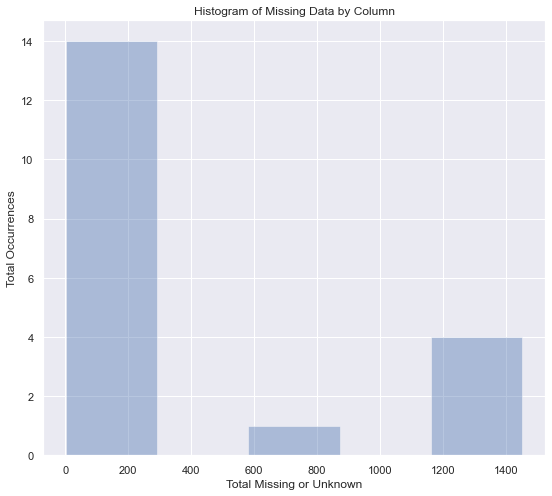

In [4]:
# Investigate patterns in the amount of missing data in each column.

# plt.rcParams.update({'figure.dpi':100})

plt.figure(figsize=(9, 8))
ax = sns.distplot(nan_count, kde=False)
ax.set_title('Histogram of Missing Data by Column')
ax.set(xlabel='Total Missing or Unknown', ylabel='Total Occurrences')
plt.show()

# Uncomment this line to save the figure.
# plt.savefig('../reports/figures/MissingDatabyCol_Histogram.svg')

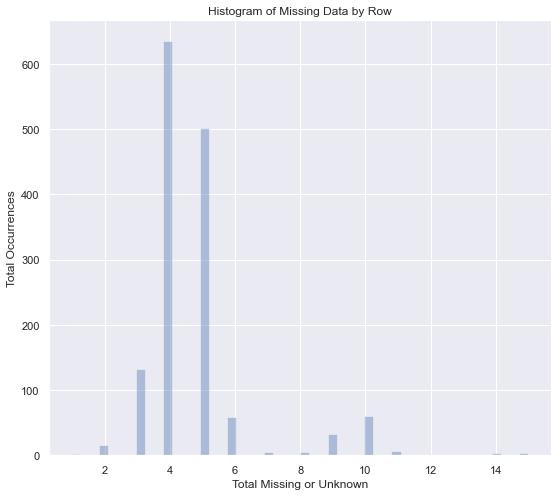

In [5]:
nan_rows = features_raw.isna().sum(axis=1)
plt.figure(figsize=(9, 8))
ax = sns.distplot(nan_rows, kde=False)
ax.set_title('Histogram of Missing Data by Row')
ax.set(xlabel='Total Missing or Unknown', ylabel='Total Occurrences')
plt.show()

# Uncomment this line to save the figure.
# plt.savefig('../reports/figures/MissingDatabyRow_Histogram.svg')

#### Assessment Summary

There is a fair amount of missing data in this dataset. Four features in particular (PoolQC, MiscFeature, Alley, Fence) contain >50% missing or unknown values. We intend to indicate the presence of these missing values so this doesn't present much of a problem.

In [6]:
categorical_cols = features_raw.select_dtypes(include=object).columns
numerical_cols = features_raw.select_dtypes(include=np.number).columns

In [7]:
# Perform One-Hot Encoding on our Categorical Data

features_enc = features_raw.copy()
onehot_df = features_enc.drop(columns=categorical_cols)
features_onehot_enc = pd.get_dummies(features_enc[categorical_cols], dummy_na=True)
onehot_df[features_onehot_enc.columns] = features_onehot_enc

# Uncomment this line to export DataFrame
# onehot_df.to_csv('../data/interim/onehot_df.csv')

# Print the number of features after one-hot encoding
encoded = list(onehot_df.columns)
print(f'{len(encoded)} total features after one-hot encoding.')

# Uncomment the following line to see the encoded feature names
# print(encoded)

331 total features after one-hot encoding.


In [8]:
onehot_df.isna().sum().sort_values().tail(3)

MasVnrArea       8
GarageYrBlt     81
LotFrontage    259
dtype: int64

In [9]:
nan_labels = ['MasVnrArea_nan', 'GarageYrBlt_nan', 'LotFrontage_nan']
encoded.extend(nan_labels)

In [10]:
imp = IterativeImputer(missing_values=np.nan, random_state=5, max_iter=20, add_indicator=True)
imputed_arr = imp.fit_transform(onehot_df)
features_imputed = pd.DataFrame(imputed_arr, columns=encoded)

# Uncomment this line to export DataFrame
# features_imputed.to_csv('../data/interim/features_imputed.csv')

### Feature Transformation
#### Transforming Skewed Continuous Features

A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number. Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. We'll need to check the following continuous data features for 'skew'.

- LotFrontage
- LotArea
- MasVnrArea
- BsmtFinSF1
- BsmtFinSF2
- TotalBsmtSF
- 1stFlrSF
- 2ndFlrSF
- LowQualFinSF
- GrLivArea
- GarageArea
- WoodDeckSF
- OpenPorchSF
- EnclosedPorch
- 3SsnPorch
- ScreenPorch
- PoolArea
- MiscVal

In [11]:
# cols = ['PoolQC', 'MiscFeature', 'Alley', 'Fence']
# features_cleaned = features_raw.drop(columns=cols)
# dropped_cols = cols

# Uncomment this line to export DataFrame
# features_cleaned.to_csv('../data/interim/features_cleaned.csv')

In [12]:
continuous_cols = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF', '1stFlrSF', 
        '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
        'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']

skew = features_imputed[continuous_cols].skew().sort_index()
skew

1stFlrSF          1.376757
2ndFlrSF          0.813030
3SsnPorch        10.304342
BsmtFinSF1        1.685503
BsmtFinSF2        4.255261
EnclosedPorch     3.089872
GarageArea        0.179981
GrLivArea         1.366560
LotArea          12.207688
LotFrontage       1.959517
LowQualFinSF      9.011341
MasVnrArea        2.666536
MiscVal          24.476794
OpenPorchSF       2.364342
PoolArea         14.828374
ScreenPorch       4.122214
TotalBsmtSF       1.524255
WoodDeckSF        1.541376
dtype: float64

In [13]:
# Show columns with skew greater than 2 * Standard Error
skew > 2 * features_imputed[continuous_cols].sem().sort_index()

1stFlrSF         False
2ndFlrSF         False
3SsnPorch         True
BsmtFinSF1       False
BsmtFinSF2       False
EnclosedPorch    False
GarageArea       False
GrLivArea        False
LotArea          False
LotFrontage       True
LowQualFinSF      True
MasVnrArea       False
MiscVal          False
OpenPorchSF      False
PoolArea          True
ScreenPorch       True
TotalBsmtSF      False
WoodDeckSF       False
dtype: bool

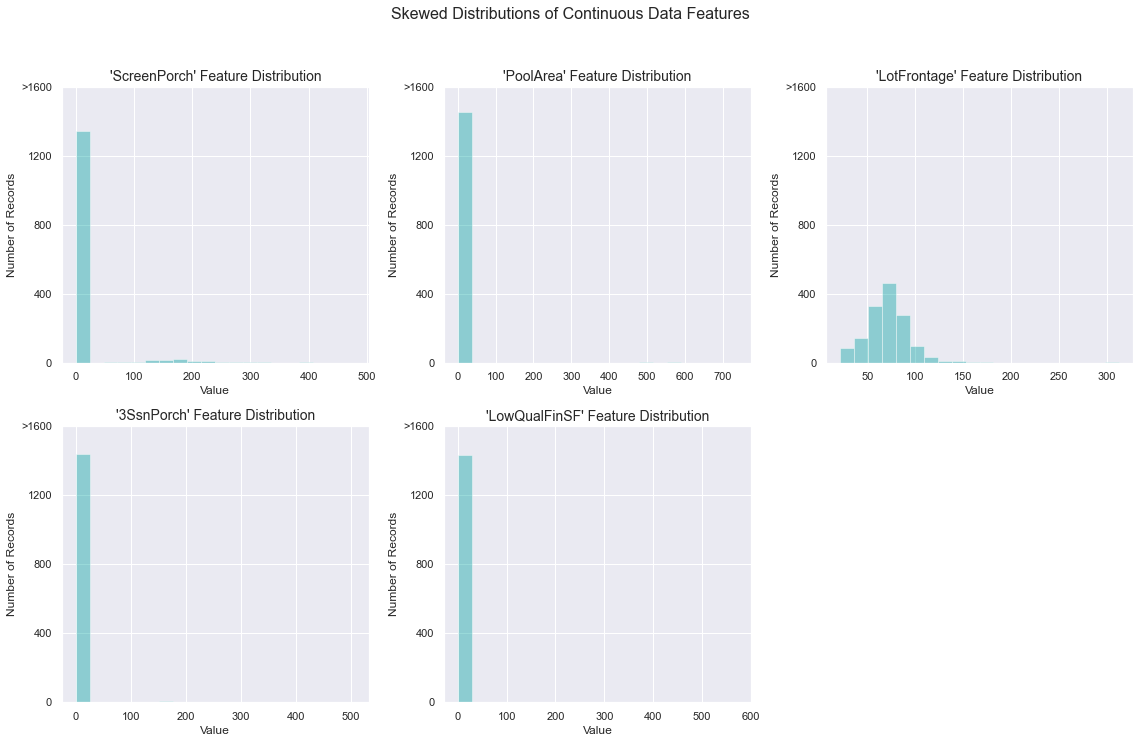

In [14]:
skewed = ['ScreenPorch', 'PoolArea', 'LotFrontage', '3SsnPorch', 'LowQualFinSF']

fig = plt.figure(figsize = (16,10));

# Skewed feature plotting
for i, feature in enumerate(skewed):
    ax = fig.add_subplot(2, 3, i+1)
    sns.distplot(features_imputed[feature], kde=False, bins=20, color='#00A0A0')
    ax.set_title("'%s' Feature Distribution"%(feature), fontsize = 14)
    ax.set_xlabel("Value")
    ax.set_ylabel("Number of Records")
    ax.set_ylim((0, 1600))
    ax.set_yticks([0, 400, 800, 1200, 1600])
    ax.set_yticklabels([0, 400, 800, 1200, ">1600"])

# Plot aesthetics
fig.suptitle("Skewed Distributions of Continuous Data Features", \
        fontsize = 16, y = 1.03)

fig.tight_layout()

# Uncomment this line to save the figure.
# plt.savefig('../reports/figures/Skewed_Distributions.svg')

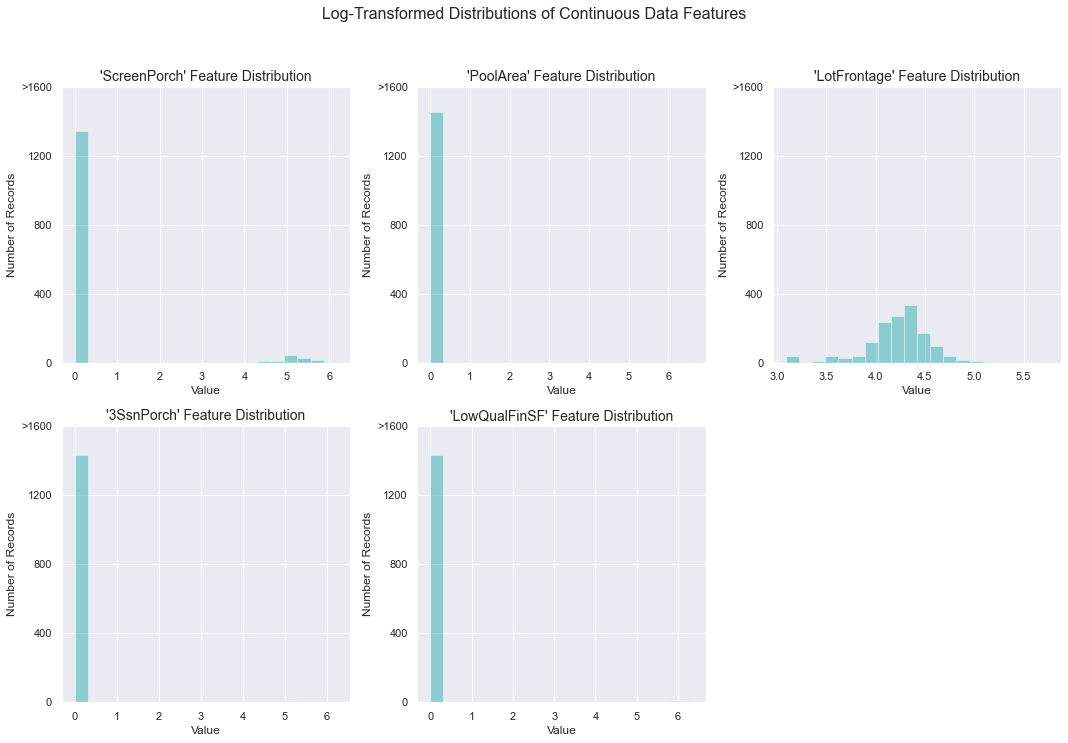

In [15]:
features_log_xformed = pd.DataFrame(data = features_imputed)
features_log_xformed[skewed] = features_imputed[skewed].apply(lambda x: np.log(x + 1))

fig = plt.figure(figsize = (15,10));

# Skewed feature plotting
for i, feature in enumerate(skewed):
    ax = fig.add_subplot(2, 3, i+1)
    sns.distplot(features_log_xformed[feature], kde=False, bins=20, color='#00A0A0')
    ax.set_title("'%s' Feature Distribution"%(feature), fontsize = 14)
    ax.set_xlabel("Value")
    ax.set_ylabel("Number of Records")
    ax.set_ylim((0, 1600))
    ax.set_yticks([0, 400, 800, 1200, 1600])
    ax.set_yticklabels([0, 400, 800, 1200, ">1600"])

# Plot aesthetics
fig.suptitle("Log-Transformed Distributions of Continuous Data Features", \
        fontsize = 16, y = 1.03)

fig.tight_layout()

# Uncomment this line to save the figure.
# plt.savefig('../reports/figures/Log_Xformed_Distributions.svg')

### Feature Scaling
#### Normalizing Numerical Features

In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution. Normalization does, however,  ensure that each feature is treated equally when applying supervised learners.

In [16]:
# Initialize scaler, then apply it to the features
scaler = StandardScaler()
numerical = features_log_xformed.select_dtypes(include=np.number).columns

features_scaled = pd.DataFrame(data = features_log_xformed)
features_scaled[numerical] = scaler.fit_transform(features_log_xformed[numerical])

features_final = features_scaled.copy()

# Uncomment this line to export DataFrame
# features_scaled.to_csv('../data/interim/features_scaled.csv')

# Uncomment this line to export DataFrame
# features_final.to_csv('../data/interim/features_final.csv')

# Show an example of a record with scaling applied
features_scaled.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan,MasVnrArea_nan,GarageYrBlt_nan,LotFrontage_nan
0,0.073375,-0.091181,-0.207142,0.651479,-0.517200,1.050994,0.878668,0.509161,0.575425,-0.288653,...,-0.272616,-0.052414,-0.091035,-0.117851,0.467651,-0.305995,0.0,-0.464385,-0.074227,-0.24236
1,-0.872563,0.516319,-0.091886,-0.071836,2.179628,0.156734,-0.429577,-0.575980,1.171992,-0.288653,...,-0.272616,-0.052414,-0.091035,-0.117851,0.467651,-0.305995,0.0,-0.464385,-0.074227,-0.24236
2,0.073375,0.040680,0.073480,0.651479,-0.517200,0.984752,0.830215,0.320922,0.092907,-0.288653,...,-0.272616,-0.052414,-0.091035,-0.117851,0.467651,-0.305995,0.0,-0.464385,-0.074227,-0.24236
3,0.309859,-0.324876,-0.096897,0.651479,-0.517200,-1.863632,-0.720298,-0.575980,-0.499274,-0.288653,...,3.668167,-0.052414,-0.091035,-0.117851,-2.138345,-0.305995,0.0,-0.464385,-0.074227,-0.24236
4,0.073375,0.659305,0.375148,1.374795,-0.517200,0.951632,0.733308,1.361771,0.463568,-0.288653,...,-0.272616,-0.052414,-0.091035,-0.117851,0.467651,-0.305995,0.0,-0.464385,-0.074227,-0.24236


### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [ ]:
# train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    saleprice, 
                                                    test_size = 0.2,
                                                    random_state = 5)

# Show the results of the split
print(f'Training set has {X_train.shape[0]} samples.')
print(f'Testing set has {X_test.shape[0]} samples.')

In [ ]:
# Stratified Shuffle Split - Come back to this later
# from sklearn.model_selection import StratifiedShuffleSplit
# ss = StratifiedShuffleSplit(test_size=0.2, random_state=5)

# i = 0
# for train_idx, test_idx in ss.split(np.zeros(features_final.shape[0]), features_final['OverallQual']):
#     X_train = features_final.iloc[train_idx]
#     y_train = saleprice.iloc[train_idx]
#     X_test = features_final.iloc[test_idx]
#     y_test = saleprice.iloc[test_idx]

# # Show the results of the split
# print(f'Training set has {X_train.shape[0]} samples.')
# print(f'Testing set has {X_test.shape[0]} samples.')